In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Preprocessing

In [3]:
# load the dataset
# '\t' is the delimiter used in the file, indicating that columns are separated by tabs
df = pd.read_csv('/kaggle/input/english-to-nepali-text/npi.txt', delimiter='\t', header=None, names=['English', 'Nepali', 'Attribution'])

# This is done to verify that the data has been loaded correctly
df.head()

,English,Nepali,Attribution
0,Who?,को?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hide.,लुकाउनुहोस्।,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
2,Hide.,लुक।,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
3,Stay.,बस्नुहोस्।,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
4,Hello!,नमस्ते!,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [4]:
# drop Attribution column as it it irrelevant
df.drop(columns=['Attribution'], inplace=True)

In [5]:
# new dataframe with only english (source) and nepali (target) sentences
df.head()

,English,Nepali
0,Who?,को?
1,Hide.,लुकाउनुहोस्।
2,Hide.,लुक।
3,Stay.,बस्नुहोस्।
4,Hello!,नमस्ते!


In [6]:
# check to see how many rows of data we have
len(df)

2689

In [7]:
def preprocess_sentence(s):
    """
    Preprocesses a given sentence by converting it to lowercase, adding spaces around punctuation marks, 
    removing special characters, digits, and extra spaces, and stripping leading and trailing whitespaces.
    
    Args:
        s (str): The input sentence to be preprocessed.
        
    Returns:
        str: The preprocessed sentence.
    """
    # Convert the sentence to lowercase
    s = s.lower()
    
    # Add spaces around punctuation marks like periods, question marks, exclamation marks, commas, and other specific punctuation marks used in Nepali
    s = re.sub(r"([?.!।,])", r" \1 ", s)
    
    # Remove special characters like '@' and '#'
    s = re.sub(r'[@#]', '', s)
    
    # Remove digits from the sentence
    s = re.sub(r'\d+', '', s)
    
    # Replace multiple spaces with a single space
    s = re.sub(r'[" "]+', " ", s)
    
    # Remove leading and trailing whitespaces
    s = s.strip()
    
    return s


In [8]:
def create_word_list(x):
    """
    Tokenizes a list of sentences and creates a vocabulary dictionary.

    Args:
        x (list): A list of strings where each string represents a sentence.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: A NumPy array of tokenized representations of input sentences.
                             Each sentence in the input list is tokenized into a sequence of integers.
                             The output array is of dtype=object because it's a list of lists.
            - dict: A dictionary that maps words to their integer indices in the vocabulary.
                    Special tokens '<pad>' and '<unk>' are included in the vocabulary for padding
                    and unknown words, respectively.
    """
    # Build the word list from the training data
    word_list = [word for sent in x for word in sent.split()]

    # Count word frequencies
    corpus_ = Counter(word_list)

    # Create the one-hot dictionary
    vocab = {w: i + 2 for i, (w, _) in enumerate(corpus_.items())}  # Start indexing from 2 (0 reserved for padding, 1 for unknown word)
    vocab['<pad>'] = 0  # Padding token
    vocab['<unk>'] = 1  # Unknown word token

    return vocab

In [9]:
def tokenize(x, vocab):
    # Tokenize the training data
    final_list = []
    for sent in x:
        tokenized_sent = [vocab.get(word, 1) for word in sent.split()]  # Use vocab.get() to handle unknown words
        final_list.append(tokenized_sent)
    return final_list

In [10]:
def create_inverse_vocab(vocab):
    """
    Create an inverse vocabulary mapping from a given vocabulary.
    
    Args:
    - vocab (dict): Vocabulary mapping (word to token).
    
    Returns:
    - Inverse vocabulary mapping (token to word).
    """
    inv_vocab = {token: word for word, token in vocab.items()}
    return inv_vocab

In [11]:
preprocessed_english = df.loc[:, 'English'].apply(preprocess_sentence)
preprocessed_nepali = df.loc[:, 'Nepali'].apply(preprocess_sentence)

In [12]:
# check to see new preprocessed sentences
preprocessed_english.head()

0      who ?
1     hide .
2     hide .
3     stay .
4    hello !
Name: English, dtype: object

In [13]:
# check to see new preprocessed sentences
preprocessed_nepali.head()

0             को ?
1    लुकाउनुहोस् ।
2            लुक ।
3      बस्नुहोस् ।
4         नमस्ते !
Name: Nepali, dtype: object

In [14]:
# add <sos> and <eos> token for all sentences
nepali_sentences_preprocessed = preprocessed_nepali.apply(lambda x: (' ').join(['<sos>', x, '<eos>']))
english_sentences_preprocessed = preprocessed_english.apply(lambda x: (' ').join(['<sos>', x, '<eos>']))

In [15]:
# check to see tokens
nepali_sentences_preprocessed.head(6)

0             <sos> को ? <eos>
1    <sos> लुकाउनुहोस् । <eos>
2            <sos> लुक । <eos>
3      <sos> बस्नुहोस् । <eos>
4         <sos> नमस्ते ! <eos>
5        <sos> मुस्कान । <eos>
Name: Nepali, dtype: object

In [16]:
# check to see tokens
english_sentences_preprocessed.head(6)

0      <sos> who ? <eos>
1     <sos> hide . <eos>
2     <sos> hide . <eos>
3     <sos> stay . <eos>
4    <sos> hello ! <eos>
5    <sos> smile . <eos>
Name: English, dtype: object

In [17]:
english_vocab = create_word_list(english_sentences_preprocessed)
nepali_vocab = create_word_list(nepali_sentences_preprocessed)

In [18]:
# check the length of English Vocab and print index some words
print(f"Unique English words in our vocabulary {len(english_vocab)}")
print(f"Index for the word 'tom' in the english vocab dict: {english_vocab['tom']}")

Unique English words in our vocabulary 2000
Index for the word 'tom' in the english vocab dict: 16


In [19]:
# check the length of Nepali Vocab and print index some words
print(f"Unique Nepali words in our vocabulary {len(nepali_vocab)}")
print(f"Index for the word '।' in the english vocab dict: {nepali_vocab['।']}")

Unique Nepali words in our vocabulary 3060
Index for the word '।' in the english vocab dict: 7


In [20]:
# create a inverse of out english and nepali vocab dictionaries mapping tokens to words, which will be 
# later used for decoding translations
inv_nepali = create_inverse_vocab(nepali_vocab)
inv_english = create_inverse_vocab(english_vocab)

In [21]:
# split data into training and testing set
X_train_eng, X_test_eng, y_train_nep, y_test_nep = train_test_split(english_sentences_preprocessed, nepali_sentences_preprocessed, test_size = 0.1, random_state = 42, shuffle = True)

In [22]:
# tokenize the training and testing data by converting the words in the sentences to their respective
# index in the english and nepali vocab
english_tokens_train = tokenize(X_train_eng, english_vocab)
english_tokens_test = tokenize(X_test_eng, english_vocab)

nepali_tokens_train = tokenize(y_train_nep, nepali_vocab)
nepali_tokens_test = tokenize(y_test_nep, nepali_vocab)

In [23]:
# conducting a test to check whether the tokenizer, vocabs and inv tokens work as intended


nepali_sentence = " ".join([inv_nepali[token_id] for token_id in nepali_tokens_train[3]])
english_sentence = " ".join([inv_english[token_id] for token_id in english_tokens_train[3]])

# Print the concatenated sentences
print("Nepali Sentence:", nepali_sentence)
print("English Sentence:", english_sentence)

assert nepali_sentence == '<sos> के तिमी हामीले तिमीलाई मद्दत गरुन भन्ने चाहान्छौ ? <eos>', 'tokenizer or nepali vocabulary or inv nepali vocab is problamatic'
assert english_sentence == '<sos> do you want us to help you ? <eos>', 'tokenizer or english vocabulary or inv english vocab is problamatic'

print('Tokenizer, vocabulary and inverse vocabs are working as intended')

Nepali Sentence: <sos> के तिमी हामीले तिमीलाई मद्दत गरुन भन्ने चाहान्छौ ? <eos>
English Sentence: <sos> do you want us to help you ? <eos>
Tokenizer, vocabulary and inverse vocabs are working as intended


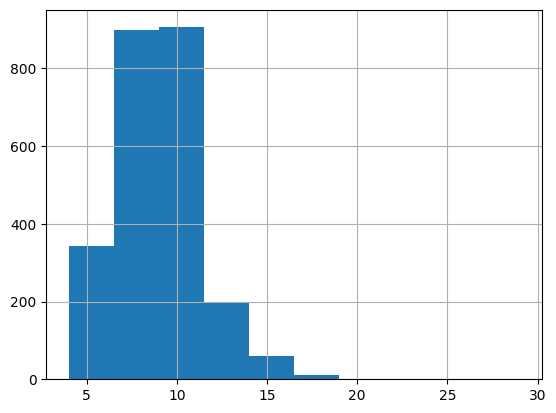

count    2420.000000
mean        8.773554
std         2.289858
min         4.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        29.000000
dtype: float64

In [24]:
# checking to see the maximum length of sequences in the english tokens
rev_len = [len(i) for i in english_tokens_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [25]:
def padding_(sentences, seq_len):
    """
    Pads or truncates a list of sentences to a specified sequence length.

    Args:
        sentences (list of lists): A list where each element is a list representing a sentence with tokenized words.
        seq_len (int): The desired sequence length for padding or truncation.

    Returns:
        numpy.ndarray: A 2D NumPy array of shape (num_sentences, seq_len).
                       Each row represents a sentence with padded or truncated tokens.
                       If the original sentence length is greater than seq_len, it is truncated;
                       if it is less than seq_len, it is padded with zeros.
    """
    # Initialize a NumPy array to store the padded or truncated sentences
    features = np.zeros((len(sentences), seq_len), dtype=int)
    
    # Iterate over each sentence in the input list
    for ii, review in enumerate(sentences):
        # Check if the length of the sentence is not zero
        if len(review) != 0:
            # If the length of the sentence is less than seq_len, pad it with zeros
            # If it is greater than seq_len, truncate it
            features[ii, :len(review)] = np.array(review)[:seq_len]
    
    return features

In [26]:
# pad all the tokenized sentences for batch processing to same sequence length ie 25
x_train_pad_eng = padding_(english_tokens_train,25)
x_test_pad_eng = padding_(english_tokens_test,25)
y_train_pad_nep = padding_(nepali_tokens_train,25)
y_test_pad_nep = padding_(nepali_tokens_test,25)

In [27]:
# check padding
print(x_train_pad_eng.shape)
print(x_test_pad_eng.shape)
print(y_train_pad_nep.shape)
print(y_test_pad_nep.shape)

(2420, 25)
(269, 25)
(2420, 25)
(269, 25)


In [28]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad_eng), torch.from_numpy(y_train_pad_nep))
valid_data = TensorDataset(torch.from_numpy(x_test_pad_eng), torch.from_numpy(y_test_pad_nep))

# dataloaders
batch_size = 50

# create DataLoader for model training and testing of dimensions 50 x 25 ( batch_size x sequence_length)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [29]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


# check the dimensions for each batch
print(f'Sample input size: {sample_x.size()}')
print(f'Sample target size: {sample_y.size()}')

Sample input size: torch.Size([50, 25])
Sample target size: torch.Size([50, 25])


## Model Building

In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout = 0.5):
        """
        Encoder module of a sequence-to-sequence model.
        
        Args:
            input_dim (int): The size of the input vocabulary.
            emb_dim (int): The dimensionality of the embedding layer.
            hid_dim (int): The dimensionality of the hidden states.
            n_layers (int): The number of layers in the LSTM.
            dropout (float): The dropout probability.
        """
        super(Encoder, self).__init__()
        
        # Initialize encoder attributes
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        # Embedding layer to convert input tokens into dense vectors
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        
        # LSTM layer to process the embedded input sequences
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        """
        Forward pass of the encoder.
        
        Args:
            src (torch.Tensor): Input tensor of shape (batch_size, seq_len)
        
        Returns:
            torch.Tensor: Output tensor from the LSTM layer of shape (batch_size, seq_len, hid_dim)
            torch.Tensor: Final hidden state of the LSTM of shape (num_layers, batch_size, hid_dim)
            torch.Tensor: Final cell state of the LSTM of shape (num_layers, batch_size, hid_dim)
        """
        # Embed the input tokens
        embedded = self.dropout(self.embedding(src))
        
        # Pass the embedded sequences through the LSTM
        outputs, (hidden, cell) = self.rnn(embedded)
        
        return outputs, hidden, cell

In [31]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout = 0.5):
        """
        Decoder module of a sequence-to-sequence model.

        Args:
            output_dim (int): The size of the output vocabulary.
            emb_dim (int): The dimensionality of the embedding layer.
            hidden_dim (int): The dimensionality of the hidden states.
            n_layers (int): The number of layers in the LSTM.
            dropout (float): The dropout probability.
        """
        super().__init__()
        
        # Initialize decoder attributes
        self.output_dim = output_dim
        
        # Embedding layer to convert output tokens into dense vectors
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        
        # LSTM layer to process the embedded output sequences
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        
        # Fully connected layer to map LSTM output to output dimension
        self.fc_out = nn.Linear(hidden_dim, output_dim, bias = False)
        
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, encoder_hidden, encoder_cell):
        """
        Forward pass of the decoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size,)
            encoder_hidden (torch.Tensor): Final hidden state of the encoder LSTM of shape (num_layers, batch_size, hid_dim)
            encoder_cell (torch.Tensor): Final cell state of the encoder LSTM of shape (num_layers, batch_size, hid_dim)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim)
            torch.Tensor: Hidden state tensor of shape (num_layers, batch_size, hidden_dim)
            torch.Tensor: Cell state tensor of shape (num_layers, batch_size, hidden_dim)
        """
        # Initialize the hidden and cell states with the encoder final states
        hidden = encoder_hidden
        cell = encoder_cell

        # Embed the input tokens
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (batch_size, 1, emb_dim)

        # Pass the embedded sequences through the LSTM
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (batch_size, 1, hidden_dim)

        # Map LSTM output to output dimension
        predictions = self.fc_out(outputs)
        # predictions shape: (batch_size, 1, output_dim)

        # Remove the unnecessary dimension
        predictions = predictions.squeeze(1)
        # predictions shape: (batch_size, output_dim)

        return predictions, hidden, cell

In [32]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Sequence-to-sequence model consisting of an encoder and a decoder.

        Args:
            encoder (Encoder): Encoder module.
            decoder (Decoder): Decoder module.
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.8):
        """
        Forward pass of the sequence-to-sequence model.

        Args:
            source (torch.Tensor): Input tensor of shape (batch_size, src_seq_len), (50 x 25) in our case.
            target (torch.Tensor): Target tensor of shape (batch_size, tgt_seq_len), (50 x 25) in our case.
            teacher_force_ratio (float, optional): Probability of using teacher forcing. Default: 0.8.

        Returns:
            torch.Tensor: Output tensor of shape (tgt_seq_len, batch_size, output_dim), (25, 50, 3060) in our case.
        """
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_dim

        # Initialize outputs tensor to store decoder predictions
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(source.device)

        # Encode the source sequence
        _, hidden, cell = self.encoder(source)

        # Initialize the input to the decoder with the start token
        x = target[:, 0].unsqueeze(1)

        # Iterate over each token in the target sequence
        for t in range(1, target_len):
            # Use previous hidden and cell states as context from the encoder
            output, hidden, cell = self.decoder(x, hidden, cell)
            # Store the decoder prediction
            outputs[t] = output
            # Determine the next input to the decoder using teacher forcing
            x = target[:, t].unsqueeze(1) if random.random() < teacher_force_ratio else output.argmax(1).unsqueeze(1)

        return outputs

In [33]:
# initialize hyperparamenters
INPUT_DIM = len(english_vocab)
OUTPUT_DIM = len(nepali_vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 1024
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
learning_rate = 0.0005

epochs = 100

In [34]:
# initialize the encoders and decoders
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

In [35]:
# Initialize sequence-to-sequence model, its optimizer and the loss
model = Seq2Seq(enc, dec).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-5)
TRG_PAD_IDX = nepali_vocab['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [36]:
def train_model(model, optimizer, criterion, train_loader, val_loader, device, num_epochs, checkpoint_dir, patience=5, min_delta=0.0001):
    """
    Train a sequence-to-sequence model using the specified data loaders.

    Args:
        model (nn.Module): The sequence-to-sequence model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
        train_loader (torch.utils.data.DataLoader): Data loader for training data.
        val_loader (torch.utils.data.DataLoader): Data loader for validation data.
        device (torch.device): Device on which to perform computations (e.g., 'cpu' or 'cuda').
        num_epochs (int): Number of epochs to train the model.
        checkpoint_dir (str): Directory to save model checkpoints.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Default: 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Default: 0.0001.
    """
    for epoch in range(num_epochs):
        # Create directory for saving checkpoints if it does not exist
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        # Initialize variables for early stopping
        best_loss = float('inf')
        epochs_no_improve = 0

        print(f"[Epoch {epoch+1} / {num_epochs}]")

        # Set model to training mode
        model.train()

        train_loss = 0.0
        for source, target in train_loader:
            # Get input and targets and move to device
            inp_data = source.to(device)
            target = target.to(device)

            # Forward pass
            output = model(inp_data, target, teacher_force_ratio=0.4)

            # Reshape output and target for the loss function
            output = output[1:].reshape(-1, output.shape[2])
            target = target.t()[1:].reshape(-1) 

            # Zero gradients, compute loss, backpropagate, and update weights
            optimizer.zero_grad()
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            # Gradient descent step
            optimizer.step()

            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader)
        print(f"Training loss: {train_loss:.4f}")

        # Set model to evaluation mode for validation
        model.eval()

        val_loss = 0.0
        with torch.no_grad():
            for source, target in val_loader:
                # Get input and targets and move to device
                inp_data = source.to(device)
                target = target.to(device)

                # Forward pass
                output = model(inp_data, target, teacher_force_ratio=0)

                # Reshape output and target for the loss function
                output = output[1:].reshape(-1, output.shape[2])
                target = target.t()[1:].reshape(-1) 

                # Compute loss
                loss = criterion(output, target)
                val_loss += loss.item()

        # Average validation loss for the epoch
        val_loss /= len(val_loader)
        print(f"Validation loss: {val_loss:.4f}")
        
        # Early stopping
        if train_loss < best_loss - min_delta:
            best_loss = train_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            checkpoint_path = os.path.join(checkpoint_dir, f's2s_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')
            break
        
        # Save model checkpoint every 25 epochs
        if (epoch + 1) % 25 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f's2s_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')
            
        if (epoch == num_epochs - 1):
            checkpoint_path = os.path.join(checkpoint_dir, f's2s_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')

In [37]:
train_model(model, optimizer, criterion, train_loader, valid_loader, device, epochs,'/kaggle/working/')

[Epoch 1 / 100]
Training loss: 5.7276
Validation loss: 5.3816
[Epoch 2 / 100]
Training loss: 5.0995
Validation loss: 5.4189
[Epoch 3 / 100]
Training loss: 4.9656
Validation loss: 5.4481
[Epoch 4 / 100]
Training loss: 4.8668
Validation loss: 5.5994
[Epoch 5 / 100]
Training loss: 4.8655
Validation loss: 5.5355
[Epoch 6 / 100]
Training loss: 4.7833
Validation loss: 5.5056
[Epoch 7 / 100]
Training loss: 4.7027
Validation loss: 5.3222
[Epoch 8 / 100]
Training loss: 4.5653
Validation loss: 5.3469
[Epoch 9 / 100]
Training loss: 4.4721
Validation loss: 5.2834
[Epoch 10 / 100]
Training loss: 4.3984
Validation loss: 5.3213
[Epoch 11 / 100]
Training loss: 4.2841
Validation loss: 5.2513
[Epoch 12 / 100]
Training loss: 4.1392
Validation loss: 5.1252
[Epoch 13 / 100]
Training loss: 4.0239
Validation loss: 5.0873
[Epoch 14 / 100]
Training loss: 3.9018
Validation loss: 5.1729
[Epoch 15 / 100]
Training loss: 3.7974
Validation loss: 5.0258
[Epoch 16 / 100]
Training loss: 3.6619
Validation loss: 5.1227
[

In [38]:
# test_model = Seq2Seq(enc, dec).to(device)
# PATH = '/kaggle/input/seq2seq_epoch_300_test/pytorch/test/1/s2s_epoch_300.pth'
# test_model.load_state_dict(torch.load(PATH))
# test_model.eval()

In [39]:
def decode_sequences_batch(sequences, inv_vocab, sos_token, pad_token, eos_token):
    decoded_sentences = []
    for sequence in sequences:
        sentence = []
        for idx in sequence:
            if idx == pad_token:  # Skip <pad> tokens
                continue
            if idx == sos_token:  # Skip <sos> tokens
                continue
            if idx == eos_token:
                break
            word = inv_vocab.get(idx.item(), f"<unk:{idx.item()}>")  # Get word from inv_vocab, handle unknowns
            sentence.append(word)
        decoded_sentences.append(' '.join(sentence))
    return decoded_sentences

# Define the decode_sequence function for decoding indices to words
def decode_sequence(indices, vocab, eos_token, pad_token, sos_token):
    sentence = []
    for idx in indices:
        if idx == eos_token:
            break
        if idx != pad_token and idx != sos_token:
            sentence.append(vocab[idx])
    return ' '.join(sentence)

In [40]:
def translate_sentences(model, valid_loader, device, target_vocab, inv_vocab):
    translated_sentences = []

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for source, target in valid_loader:
            # Move source and target to device
            source = source.to(device)
            target = target.to(device)

            # Forward pass through the model
            output = model(source, target, teacher_force_ratio=0)
            output = output.permute(1,0,2)

            # Reshape output if necessary (output shape: batch_size, seq_len, vocab_size)
            print(f'Output shape: {output.shape}')# Should be [50, 25, 2879]

            # Get the predicted token indices for each sequence in the batch
            predicted_indices = output.argmax(dim=2) # Shape: [50, 25]
            print(predicted_indices.shape)

            # Decode each sequence of indices
            for indices in predicted_indices:
                decoded_sentence = decode_sequence(indices.tolist(), inv_vocab, target_vocab['<eos>'], target_vocab['<sos>'], target_vocab['<pad>'])
                translated_sentences.append(decoded_sentence)
                
            decoded_sentences_english = decode_sequences_batch(source, inv_english, english_vocab['<sos>'], english_vocab['<pad>'],  english_vocab['<eos>'])

            # We break after the first batch for demonstration
            break

    return translated_sentences, decoded_sentences_english



In [41]:
translated_sentences, source_sentences = translate_sentences(model, valid_loader, device, nepali_vocab, inv_nepali)

# Assuming translate_sentences returns a tuple of lists
for i, (translated, source) in enumerate(zip(translated_sentences, source_sentences)):
    print(f"{i})Source: {source} \n Translated: {translated} \n")
    i += 1


Output shape: torch.Size([50, 25, 3060])
torch.Size([50, 25])
0)Source: what's your favorite kind of pizza ? 
 Translated: यो चलचित्रमा तपाईलाई मूल्य पर्ने पात्र हो ? 

1)Source: i miss you badly . 
 Translated: मलाई तिम्रो परोपकार याद आइरहेको छ । 

2)Source: it's not healthy to eat and run . 
 Translated: यो संस्कृतिको बारेमा जान्न पाउँदा रमाइलो हुन्छ । 

3)Source: don't cry in public . 
 Translated: बाहिर बाहिर नजानुहोस् । 

4)Source: tom doesn't seem to agree with you at all . 
 Translated: टम तपाईंसँग बिलकुलै सहमत छैन जस्तो देखिन्छ । 

5)Source: tom is older than i thought . 
 Translated: टम अझै पनि मेरो नाम हो । 

6)Source: aren't you allergic to anything ? 
 Translated: के तपाइँ सोमबार एक्लै लोकप्रिय हुनुहुन्थ्यो ? 

7)Source: i don't know this part of town well . 
 Translated: मलाई थाहा छैन तिमी के भन्दै छौ । 

8)Source: who's driving ? 
 Translated: कसले गाउँदै छ ? 

9)Source: i'm pretty sure tom's competent . 
 Translated: म टम क्यानेडियन हो भनेर पक्का छु । 

10)Source: i have